## 构建交易策略

In [22]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

In [2]:
with open("data/models.bin", "rb")as f:
    models = pickle.load(f)
    f.close()
data = pd.read_csv("data/preprocessed.csv")
with open("data/SSDs.bin", "rb") as f:
    SSDs = pickle.load(f)
    f.close()

In [3]:
# 具有协整关系的商品
idxs = list(map(lambda x:x[0], models))
pairs = [SSDs[i] for i in idxs]

In [4]:
# with open("data/pairs.bin", "wb") as f:
#     pickle.dump(pairs, f)
#     f.close()

## 交易

In [5]:
def getPrice(data, asset, start, end):
    '''
    @Description
    获取名称为asset的前t价格序列
    ------------
    @Params
    data, DataFrame
    asset, str
    start, end , int, 时间节点
    ------------
    @Returns
    prices, array
    '''
    return data[data["asset"]==asset].sort_values(by=["date"]).iloc[start:end, 2].values

In [6]:
# 从2018-01-01开始
data = data[data["date"]>="2018-01-01"]

In [7]:
# data.to_csv("2018data.csv", index=False)

In [8]:
# 形成期12个月 交易期6个月
dates = np.sort(data["date"].unique())
form_days = sum(dates<="2019-01-01")
total_days = sum(dates<="2020-01-01")

In [9]:
form_days, total_days

(243, 487)

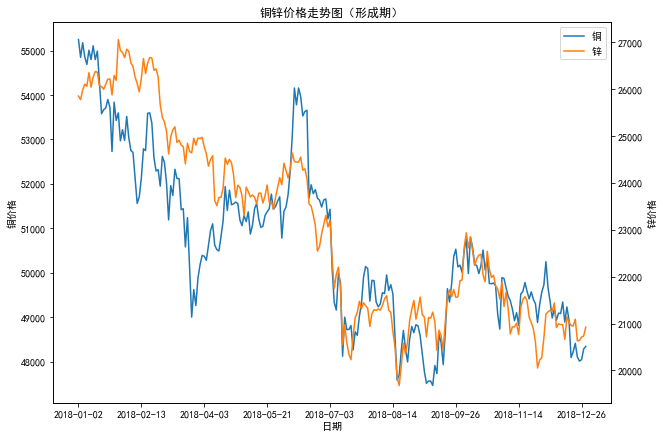

In [44]:
# 价格走势图
pair1 = "铜"
pair2 = "锌"
fig, ax = plt.subplots(figsize=(10, 7))
d1 = data[data["asset"]==pair1].iloc[:form_days, :]
d2 = data[data["asset"]==pair2].iloc[:form_days, :]
line1 = ax.plot(d1.date, d1.close, label=pair1, c="#1f77b4")
ax2 = ax.twinx()
line2 = ax2.plot(d2.date, d2.close, label=pair2,c="#ff7f0e")
ax.legend(line1+line2, [pair1, pair2])
ax.set_xlabel(u"日期")
ax.set_ylabel(f"{pair1}价格")
ax2.set_ylabel(f"{pair2}价格")
ax.set_title(f"{pair1}{pair2}价格走势图（形成期）")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.savefig(f"{pair1}{pair2}价格走势图形成期.jpg", dpi=300)
plt.show()

('铜-锌', 4.455198281264797)


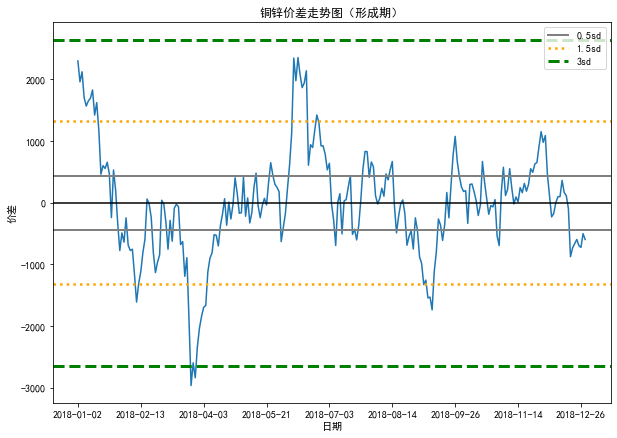

In [43]:
# 残差图
result = models[3][2]
print(SSDs[models[3][0]])
pair1 = "铜"
pair2 = "锌"
# pair1 = "天然橡胶" 
# pair2 = "铁矿石"
fig, ax = plt.subplots(figsize=(10, 7))
# d1 = data[data["asset"]==pair1].iloc[:form_days, :]
# d2 = data[data["asset"]==pair2].iloc[:form_days, :]
x = dates[:form_days]
resid = result.resid
ax.plot(x, resid)
mu = np.mean(resid)
sd = np.std(resid)
ax.axhline(y=mu,color='black')
ax.axhline(y=mu+0.5*sd,color='gray',ls='-',lw=2, label="0.5sd")
ax.axhline(y=mu-0.5*sd,color='gray',ls='-',lw=2)
ax.axhline(y=mu+1.5*sd,color='orange',ls=':',lw=2.5, label="1.5sd")
ax.axhline(y=mu-1.5*sd,color='orange',ls=':',lw=2.5)
ax.axhline(y=mu+3*sd,color='green',ls='--',lw=3, label="3sd") 
ax.axhline(y=mu-3*sd,color='green',ls='--',lw=3) 
ax.set_title(f"{pair1}{pair2}价差走势图（形成期）")
ax.set_ylabel("价差")
ax.set_xlabel("日期")
ax.legend()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.savefig(f"{pair1}{pair2}价差走势图形成期.jpg", dpi=300)
plt.show()

In [10]:
SSDs[models[1][0]]

('甲醇-聚丙烯', 2.548757243136044)

In [11]:
models[3][2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     841.6
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           1.40e-80
Time:                        10:27:04   Log-Likelihood:                -1992.9
No. Observations:                 243   AIC:                             3990.
Df Residuals:                     241   BIC:                             3997.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.188e+04    650.085     49.041      0.000    3.06e+04    3.32e+04
x1             0.8151      0.028     29.010      0.000       0.760       0.870
==============================================================================
Omnibus:                        8.153   Durbin-Watson:                   0.177
Prob(Omnibus):                  0.017   Jarque-Bera (JB):               14.695
Skew:                          -0.034   Prob(JB):                     0.000644
Kurtosis:                       4.203   Cond. No.                     2.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
def setyPosition(signal):
    '''
    @Description
    接受信号，设置仓位
    ------------
    @Params
    signal, int
    t, int
    positions, list
    '''
    if signal==1:
        # 反向建仓
        return -1
        # positions[t] = -1
    if signal==-1:
        return 0
        # positions[t] = 0
    if signal==2:
        # 正向建仓
        return 1
        # positions[t] = 1
    if signal==-2:
        return 0
        # positions[t] = 0

In [13]:
def signal(itv, i):
    '''
    @Description
    调整仓位信号
    ------------
    @Params
    itv, array, 残差分组情况 intervals
    i, int, 第几天
    ------------
    @Returns
    sig, int, 信号
    '''
    if itv[i-1] == 1 and itv[i] == 2:
        return 1  # 反向建仓，超过1.5sd 价差扩大，买x卖y
    if itv[i-1] == 1 and itv[i] == 0:
        return -1  # 反向平仓，卖x买y
    if itv[i-1] == -1 and itv[i] == -2:
        return 2  # 正向建仓 买y卖x
    if itv[i-1] == -1 and itv[i] == 0:
        return -2  # 正向平仓 卖y买x
    return 0  # 保持

In [14]:
def getBound(mu, sd, threshold=2):
    '''
    @Description
    获取上下界
    ------------
    @Params
    mu, sd, float, 形成期的均值标准差
    threshold, float, default 2, 多少个标准差
    ------------
    @Returns
    lower, upper, float, 上下界
    '''
    return mu-threshold*sd, mu+threshold*sd

In [15]:
def trade(intervals, y, x, tradingDates, beta):
    '''
    @Description
    交易
    ------------
    @Params
    ------------
    @Returns
    '''
    days = len(tradingDates)
    y_positions = [0 for i in range(days)]  # y的仓位
    x_positions = [0 for i in range(days)]
    size = 100  # 合约单位
    account = 0
    account_flag = 0
    profits = [0 for i in range(days)]
    returns = [0 for i in range(days)]  # 收益率
    signals = []
    num_y = 0 # 记录仓位
    num_x = 0
    for i in range(1, days):
        sig = signal(intervals, i)
        signals.append(sig)
        if sig==0:
            y_positions[i] = y_positions[i-1]
            x_positions[i] = x_positions[i-1]
            profits[i] = 0
            returns[i] = 0  # 收益率为0
            continue
        temp = setyPosition(sig)
        y_positions[i] = temp
        x_positions[i] = -temp
        if y_positions[i-1]==0 and y_positions[i]==1:
            # 正向建仓 买y卖x
            # temp = 1
            num_y = temp*size
            buy_y = num_y*y[i]
            num_x = (-(buy_y/beta/x[0])//size)*size
            buy_x = num_x*x[i]
            account_flag = account  # 记录钱包
            account -= buy_y
            account -= buy_x
            # print(f"正向建仓buy y {num_y}, sell x{num_x}")
        elif y_positions[i-1]==0 and y_positions[i]==-1:
            # 反向建仓 卖y买x
            # temp=-1
            num_y = temp*size
            buy_y = num_y*y[i]
            num_x = (-(buy_y/beta/x[0])//10)*10
            buy_x = num_x*x[i]
            account_flag = account
            account -= buy_y
            account -= buy_x
            # print(f"反向建仓sell y {num_y}, buy x{num_x}")
        elif y_positions[i-1]==1 and y_positions[i]==0:
            # 正向平仓 卖y买y
            # num_y > 0 num_x<0
            buy_y = -num_y*y[i]
            buy_x = -num_x*x[i]
            return_flag = account
            account -= buy_y
            account -= buy_x  # sell 负数买入
            profits[i] = account-account_flag
            returns[i] = profits[i]/return_flag
            # print(f"正向平仓sell y {-num_y}, buy x{-num_x}")
            num_y = 0
            num_x = 0
            account_flag = 0
        elif y_positions[i-1]==-1 and y_positions[i]==0:
            # 反向平仓 买y卖x
            # num_y<0, num_x>0
            buy_y = -num_y*y[i]
            buy_x = -num_x*x[i]
            return_flag = account
            account -= buy_y
            account -= buy_x
            profits[i] = account-account_flag
            returns[i] = profits[i]/return_flag
            # print(f"反向平仓buy y {-num_y}, sell x{-num_x}")
            num_y = 0
            num_x = 0
            account_flag = 0
            
        
    # if num_y<0:
    #     buy_y = -num_y*y[i]
    #     buy_x = -num_x*x[i]
    #     temp = account
    #     account -= buy_y
    #     account -= buy_x
    #     profits[-1] = account-account_flag
    #     # print(f"反向平仓buy y {-num_y}, sell x{-num_x}")
    #     print(111, profits[-1])
    # elif num_y>0:
    #     # 正向平仓 卖y买y
    #     # num_y > 0 num_x<0
    #     buy_y = -num_y*y[i]
    #     buy_x = -num_x*x[i]
    #     account -= buy_y
    #     account -= buy_x  # sell 负数买入
    #     profits[-1] = account-account_flag
    #     # print(f"正向平仓sell y {-num_y}, buy x{-num_x}")
    #     print(222, profits[-1])
    return account, np.cumsum(profits), returns, y_positions
        

In [16]:
def tradeWithInit(intervals, y, x, tradingDates, beta, init=1000000):
    '''
    @Description
    设置初始交易资金
    ------------
    @Params
    ------------
    @Returns
    '''
    days = len(tradingDates)
    y_positions = [0 for i in range(days)]  # y的仓位
    x_positions = [0 for i in range(days)]
    size = 10  # 最小合约单位
    account = init # 初始1000000
    account_flag = 0
    profits = [0 for i in range(days)]
    returns = [0 for i in range(days)]  # 收益率
    signals = []
    num_y = 0 # 记录仓位
    num_x = 0
    for i in range(1, days):
        sig = signal(intervals, i)
        signals.append(sig)
        if sig==0:
            y_positions[i] = y_positions[i-1]
            x_positions[i] = x_positions[i-1]
            profits[i] = 0
            returns[i] = 0  # 收益率为0
            continue
        temp = setyPosition(sig)
        y_positions[i] = temp
        x_positions[i] = -temp
        if y_positions[i-1]==0 and y_positions[i]==1:
            # 正向建仓 买y卖x
            # temp = 1
            num_y = ((account/y[0])//size)*size
            buy_y = num_y*y[i]
            num_x = (-(buy_y/beta/x[0])//size)*size
            buy_x = num_x*x[i]
            account_flag = account  # 记录钱包
            account -= buy_y
            account -= buy_x
            # print(f"正向建仓buy y {num_y}, sell x{num_x}")
        elif y_positions[i-1]==0 and y_positions[i]==-1:
            # 反向建仓 卖y买x
            # temp=-1
            # num_y = temp*size
            num_y = -((account/y[0])//10)*10
            buy_y = num_y*y[i]
            num_x = (-(buy_y/beta/x[0])//10)*10
            buy_x = num_x*x[i]
            account_flag = account
            account -= buy_y
            account -= buy_x
            # print(f"反向建仓sell y {num_y}, buy x{num_x}")
        elif y_positions[i-1]==1 and y_positions[i]==0:
            # 正向平仓 卖y买y
            # num_y > 0 num_x<0
            buy_y = -num_y*y[i]
            buy_x = -num_x*x[i]
            return_flag = account
            account -= buy_y
            account -= buy_x  # sell 负数买入
            profits[i] = account-account_flag
            returns[i] = profits[i]/return_flag
            # print(f"正向平仓sell y {-num_y}, buy x{-num_x}")
            num_y = 0
            num_x = 0
            account_flag = 0
        elif y_positions[i-1]==-1 and y_positions[i]==0:
            # 反向平仓 买y卖x
            # num_y<0, num_x>0
            buy_y = -num_y*y[i]
            buy_x = -num_x*x[i]
            return_flag = account
            account -= buy_y
            account -= buy_x
            profits[i] = account-account_flag
            returns[i] = profits[i]/return_flag
            # print(f"反向平仓buy y {-num_y}, sell x{-num_x}")
            num_y = 0
            num_x = 0
            account_flag = 0
    return account, np.cumsum(profits), returns, y_positions
        

聚丙烯 甲醇


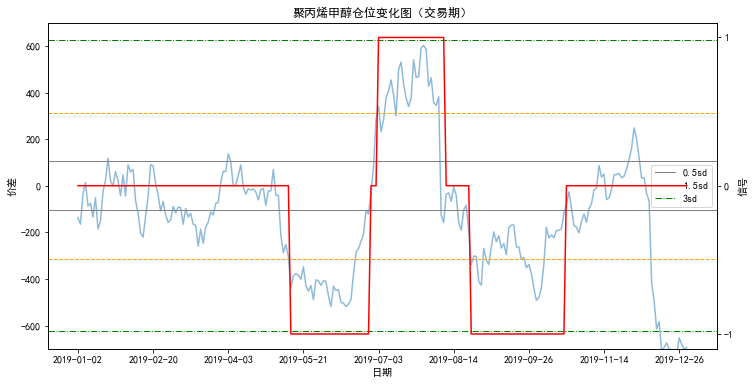

In [36]:
threshold = 1.5  # 多少个标准差触发交易
tradingDates = dates[form_days: total_days]
profits = []
init = 1e6
for i, model, result in models[1:2]:
    asset1, asset2 = SSDs[i][0].split("-")
    # 较大的为y
    y = getPrice(data, asset1, 0, form_days)
    x = getPrice(data, asset2, 0, form_days)
    if np.mean(y)<np.mean(x):
        asset1, asset2 = asset2, asset1
    print(asset1, asset2)
    # 获取交易期数据
    y = getPrice(data, asset1, form_days, total_days)
    x = getPrice(data, asset2, form_days, total_days)
    alpha = result.params[0]
    beta = result.params[1]
    resid = result.resid
    mu = np.mean(resid)
    sd = np.std(resid)
    spread = y-beta*x-alpha
    # lower, upper = getBound(mu, sd, threshold)
    # print(lower, upper, spread[0])
    level = (float('-inf'),mu-3*sd,mu-1.5*sd,mu-0.5*sd, mu+0.5*sd,mu+1.5*sd,mu+3*sd,float('inf'))
    intervals = pd.cut(spread,level,labels=False)-3
    # print(intervals)

    
    # account, profit, returns,y_positions = trade(intervals, y, x, tradingDates, beta)
    account, profit, returns, y_positions = tradeWithInit(intervals, y, x, tradingDates, beta, init)
    
    profits.append(profit)
    # print(account,profits)
# print(np.sum(profits, axis=0)[-1]/(init))
    # # 绘制累计利润
    # fig, ax = plt.subplots(figsize=(12, 6))
    # ax.plot(tradingDates, np.sum(profits, axis=0))
    # ax.set_title(f"{asset1}{asset2}配对交易利润图")
    # ax.set_ylabel("利润")
    # ax.set_xlabel("日期")
    # plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
    # # plt.savefig(f"figures/{asset1}{asset2}配对交易利润图.jpg", dpi=300)
    # plt.show()

    # # # 绘制价格区间图（交易期）
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(tradingDates, spread, alpha=0.5)
    ax2 = ax.twinx()
    ax2.set_ylabel("信号")
    ax2.set_yticks([-1,0,1,2,3])
    ax2.plot(tradingDates, [-i for i in y_positions], c="r")
#     ax.axhline(y=mu,color='black')
    ax.axhline(y=mu+0.5*sd,color='gray',ls='-',lw=1, label="0.5sd")
    ax.axhline(y=mu-0.5*sd,color='gray',ls='-',lw=1)
    ax.axhline(y=mu+1.5*sd,color='orange',ls='--',lw=1, label="1.5sd")
    ax.axhline(y=mu-1.5*sd,color='orange',ls='--',lw=1)
    ax.axhline(y=mu+3*sd,color='green',ls='-.',lw=1, label="3sd") 
    ax.axhline(y=mu-3*sd,color='green',ls='-.',lw=1) 
    ax.set_title(f"{asset1}{asset2}仓位变化图（交易期）")
    ax.set_ylabel("价差")
    ax.set_xlabel("日期")
#     ax.set_yticks([-700, -400, -200, 0, 200, 400, 700])
    ax.set_ylim(-700, 700)
    ax.legend()
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
    plt.savefig(f"{asset1}{asset2}开仓情况交易期.jpg", dpi=300)
    plt.show()

In [23]:
# temp = np.array(returns)

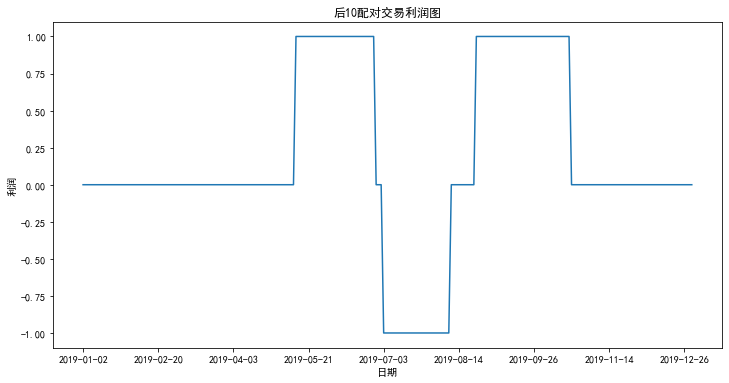

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(tradingDates, np.sum(profits, axis=0))
# ax.plot(tradingDates,np.cumprod(1+temp))
ax.plot(tradingDates, y_positions)
ax.set_title(f"后10配对交易利润图")
ax.set_ylabel("利润")
ax.set_xlabel("日期")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
# plt.savefig(f"figures/后10配对交易利润图.jpg", dpi=300)
plt.show()